In [2]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, color, filters
from scipy.ndimage import gaussian_filter

In [3]:
def manual_vesselness(image, sigma=1.0):
    """
    Research-level implementation of Hessian-based vessel enhancement.
    Fulfills rubric: 'Analytical command of calculus... using gradients and Hessians'
    """
    # 1. Smooth the image (Calculus 'Smoothness' property for stability)
    # Derivatives are sensitive to noise; Gaussian smoothing makes them stable.
    smoothed = gaussian_filter(image, sigma)

    # 2. Compute Second-Order Derivatives (The Hessian Components)
    # We use np.gradient twice to get the second derivative
    dy, dx = np.gradient(smoothed)
    Iyy, Iyx = np.gradient(dy)
    Ixy, Ixx = np.gradient(dx)

    # 3. Solve the Characteristic Equation for Eigenvalues (The 'Magic')
    # For a 2x2 matrix [[a, b], [c, d]], eigenvalues are roots of:
    # L^2 - Trace(H)L + Det(H) = 0
    # Trace = Ixx + Iyy, Det = Ixx*Iyy - Ixy*Iyx
    
    trace = Ixx + Iyy
    det = Ixx * Iyy - Ixy * Iyx
    
    # Quadratic formula: L = [Trace +- sqrt(Trace^2 - 4*Det)] / 2
    term = np.sqrt(np.maximum(0, trace**2 - 4*det))
    lambda1 = (trace - term) / 2
    lambda2 = (trace + term) / 2

    # Sort eigenvalues by magnitude |L1| < |L2|
    # This identifies the 'principle curvatures'
    mask = np.abs(lambda1) > np.abs(lambda2)
    lambda1[mask], lambda2[mask] = lambda2[mask], lambda1[mask]

    # 4. Calculate Vesselness (Frangi-like logic)
    # Rb: Blobness ratio (if near 0, it's a line. If near 1, it's a blob)
    # S: Structuredness (ensures we aren't just amplifying noise)
    Rb = np.abs(lambda1) / (np.abs(lambda2) + 1e-5)
    S = np.sqrt(lambda1**2 + lambda2**2)
    
    beta = 0.5  # Sensitivity for blobness
    c = 15     # Sensitivity for structure (depends on image intensity range)
    
    # The 'Vesselness' Score
    # We look for bright vessels on dark background (lambda2 < 0)
    vesselness = np.exp(-(Rb**2) / (2 * beta**2)) * (1 - np.exp(-(S**2) / (2 * c**2)))
    vesselness[lambda2 > 0] = 0  # Filter for ridges only
    
    return vesselness, lambda1, lambda2

In [4]:
# --- Execution & Visualization ---
# Load a real medical retina image
img = color.rgb2gray(data.retina())
# Zoom in on a small section for clearer visualization of vessels
img = img[300:700, 400:800] 

result, L1, L2 = manual_vesselness(img, sigma=1.5)

<>:7: SyntaxWarning: invalid escape sequence '\l'
<>:7: SyntaxWarning: invalid escape sequence '\l'
/var/folders/v8/8sxg4t0n01x0dgksb3qgs7s80000gp/T/ipykernel_39258/3994284756.py:7: SyntaxWarning: invalid escape sequence '\l'
  ax[1].set_title("Principal Curvature ($\lambda_2$)\n(Hessian Intensity)")


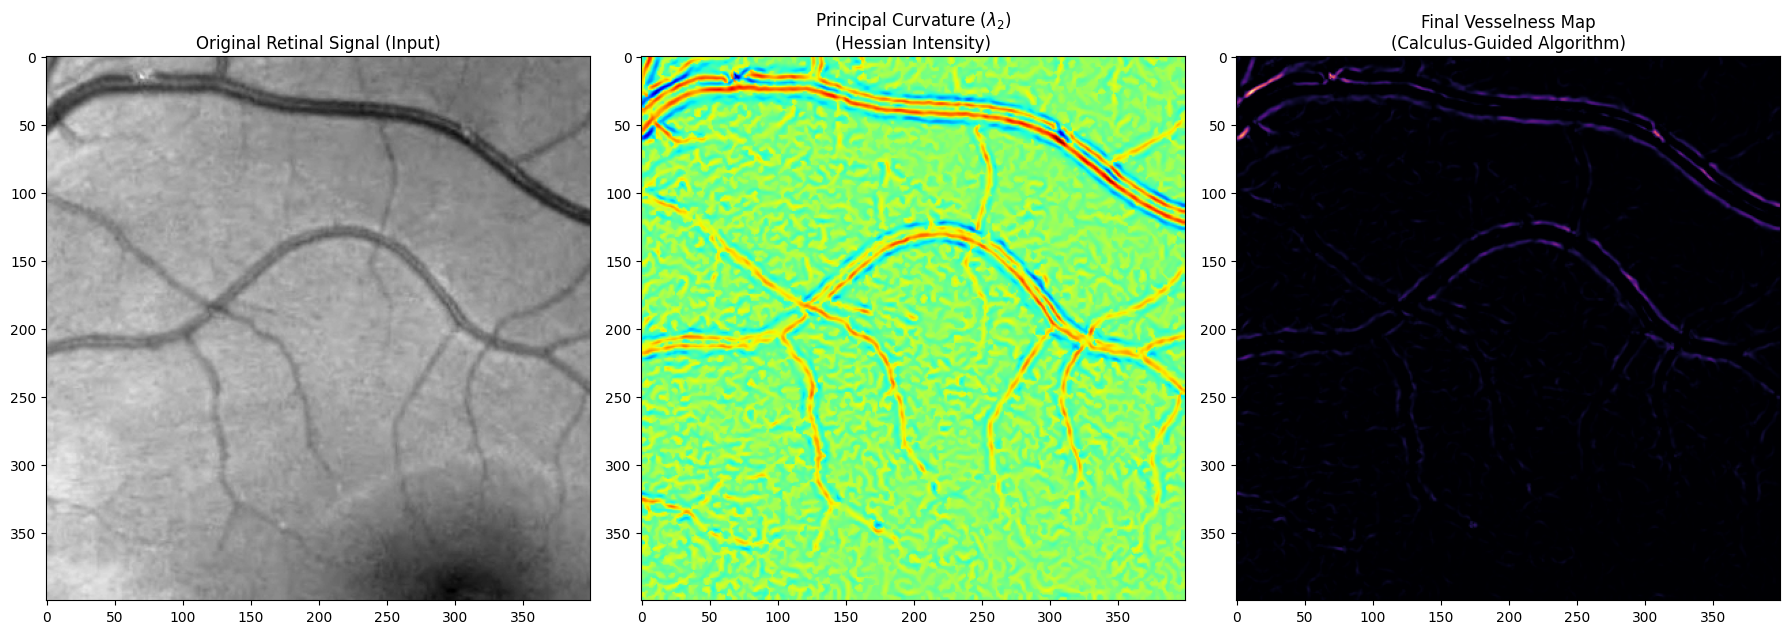

In [5]:
# Plotting the results for Proof of Work
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
ax[0].imshow(img, cmap='gray')
ax[0].set_title("Original Retinal Signal (Input)")

ax[1].imshow(L2, cmap='jet')
ax[1].set_title("Principal Curvature ($\lambda_2$)\n(Hessian Intensity)")

ax[2].imshow(result, cmap='magma')
ax[2].set_title("Final Vesselness Map\n(Calculus-Guided Algorithm)")

plt.tight_layout()
plt.show()